# PSO vs Hill Climbing on Ackley

Focus:
- **Convergence speed**: how fast each method drives the best-so-far objective down;
- **Computational complexity**: wall–clock time per run and rough time/space scaling;
- **Robustness**: performance over many random restarts;
- **Scalability**: how performance changes when we increase problem dimension.

## Import

In [1]:
import time
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

from swarm_algo.pso import ParticleSwarmOptimizer
from search_algo.hill_climbing import HillClimbing, Problem as HCProblem

OUT_PATH = "../imgs/pso_ackley/"
import os
if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH)


ModuleNotFoundError: No module named 'imageio_ffmpeg'

## Benchmark

In [ ]:
# ---- Ackley benchmark ----

def ackley_function(x, a: float = 20.0, b: float = 0.2, c: float = 2 * np.pi) -> float:
    """Standard Ackley function (global min at 0 with f(0) = 0)."""
    x = np.asarray(x, dtype=float)
    n = x.size
    sum_sq = np.sum(x * x)
    sum_cos = np.sum(np.cos(c * x))
    term1 = -a * np.exp(-b * np.sqrt(sum_sq / n))
    term2 = -np.exp(sum_cos / n)
    return term1 + term2 + a + np.e


ACKLEY_LOWER = -5.0
ACKLEY_UPPER = 5.0

## Metrics

In [ ]:
# ---- Metrics used across both algorithms ----

def convergence_auc(history: List[float]) -> float:
    """Area under best-so-far curve (lower is better)."""
    y = np.asarray(history, dtype=float)
    x = np.arange(len(y))
    return float(np.trapezoid(y, x))


def iters_to_epsilon(history: List[float], eps: float) -> Optional[int]:
    """First iteration where best-so-far <= eps. Return None if never reached."""
    y = np.asarray(history, dtype=float)
    idx = np.where(y <= eps)[0]
    return int(idx[0]) if idx.size > 0 else None


def pad_history(histories: List[List[float]]) -> np.ndarray:
    """Pad variable-length histories to same length with final value of each run."""
    max_len = max(len(h) for h in histories)
    padded = np.zeros((len(histories), max_len), dtype=float)
    for i, h in enumerate(histories):
        last = h[-1]
        padded[i, :len(h)] = h
        if len(h) < max_len:
            padded[i, len(h):] = last
    return padded


def summarize(values: List[float]) -> Tuple[float, float]:
    a = np.asarray(values, float)
    return float(a.mean()), float(a.std())


## Hill Climbing on Ackley

In [ ]:
# ---- Hill Climbing on Ackley ----

class AckleyHCProblem(HCProblem):
    """Ackley wrapper for Hill Climbing.

    - Search space: [ACKLEY_LOWER, ACKLEY_UPPER]^dim (continuous).
    - Neighborhood: coordinate-wise +/- step on each dimension, clipped to bounds.
    """
    def __init__(self, dim: int, step: float = 0.1, rng: Optional[np.random.Generator] = None):
        self.dim = dim
        self.step = float(step)
        self.lower = float(ACKLEY_LOWER)
        self.upper = float(ACKLEY_UPPER)
        self.rng = rng or np.random.default_rng()

    def generate_initial_solution(self) -> np.ndarray:
        return self.rng.uniform(self.lower, self.upper, size=self.dim)

    def evaluate(self, solution) -> float:
        return float(ackley_function(solution))

    def get_neighbors(self, solution) -> List[np.ndarray]:
        sol = np.asarray(solution, dtype=float)
        neighbors: List[np.ndarray] = []
        for j in range(self.dim):
            for delta in (-self.step, self.step):
                nb = sol.copy()
                nb[j] = np.clip(nb[j] + delta, self.lower, self.upper)
                neighbors.append(nb)
        return neighbors

    def is_valid(self, solution) -> bool:
        sol = np.asarray(solution, dtype=float)
        return np.all(sol >= self.lower) and np.all(sol <= self.upper)


def run_hc_ackley(
    dim: int,
    max_iters: int,
    seed: int,
    step: float = 0.1,
    variant: str = "steepest",
    verbose: bool = False,
) -> Dict:
    """Run one Hill Climbing trajectory on Ackley and collect metrics."""
    rng = np.random.default_rng(seed)
    problem = AckleyHCProblem(dim=dim, step=step, rng=rng)
    hc = HillClimbing(problem=problem, max_iters=max_iters, variant=variant, verbose=verbose)

    t0 = time.perf_counter()
    best_solution, best_fitness, all_fitness = hc.solve()
    dt = time.perf_counter() - t0

    history = all_fitness  # already best-so-far sequence by construction

    return dict(
        best_f=float(best_fitness),
        history=list(history),
        time=dt,
        n_iter=len(history) - 1,
    )


## PSO on Ackley

In [ ]:
# ---- PSO on Ackley ----

def run_pso_ackley(
    dim: int,
    max_iters: int,
    seed: int,
    n_particles: int = 40,
    mode: str = "constriction",
    phi1: float = 2.05,
    phi2: float = 2.05,
    chi: float = 0.729,
    topology: str = "ring",
    ring_neighbors: int = 2,
    velocity_clamp: float = 0.5,
    boundary_mode: str = "clip",
) -> Dict:
    """Run one PSO trajectory on Ackley and collect metrics.

    Notes
    -----
    - We minimize the Ackley function directly.
    - `history_best_f` in the PSO info object is best-so-far across iterations.
    """
    bounds = [(ACKLEY_LOWER, ACKLEY_UPPER)] * dim

    t0 = time.perf_counter()
    pso = ParticleSwarmOptimizer(
        objective=ackley_function,
        bounds=bounds,
        n_particles=n_particles,
        max_iters=max_iters,
        mode=mode,
        phi1=phi1,
        phi2=phi2,
        chi=chi,
        topology=topology,
        ring_neighbors=ring_neighbors,
        velocity_clamp=velocity_clamp,
        boundary_mode=boundary_mode,
        seed=seed,
        problem_type="continuous",
        enable_position_history=False,
        track_positions=False,
        early_stopping_rounds=None,
        tol=1e-12,
    )
    best_x, best_f, info = pso.optimize()
    dt = time.perf_counter() - t0

    return dict(
        best_f=float(best_f),
        history=list(info.history_best_f),
        time=dt,
        n_iter=info.n_iter,
    )


## Runner

In [ ]:
# ---- Multi-run wrappers for robustness & statistics ----

@dataclass
class RunSummary:
    method: str
    dim: int
    max_iters: int
    n_runs: int
    best_f_mean: float
    best_f_std: float
    auc_mean: float
    auc_std: float
    time_mean: float
    time_std: float
    iters_eps_mean: float
    iters_eps_std: float
    hit_rate: float


EPS_TARGET = 1e-3  # how close to zero we consider "good enough"


def run_many(
    method: str,
    dim: int,
    max_iters: int,
    n_runs: int,
    base_seed: int = 0,
    **algo_cfg,
) -> Tuple[RunSummary, Dict[str, List]]:
    """Run PSO or HC many times and aggregate metrics."""
    best_vals: List[float] = []
    aucs: List[float] = []
    times: List[float] = []
    iters_eps: List[float] = []
    hits: List[float] = []
    histories: List[List[float]] = []

    for i in range(n_runs):
        seed = base_seed + i
        if method.lower() == "pso":
            out = run_pso_ackley(dim=dim, max_iters=max_iters, seed=seed, **algo_cfg)
        elif method.lower() == "hc":
            out = run_hc_ackley(dim=dim, max_iters=max_iters, seed=seed, **algo_cfg)
        else:
            raise ValueError("method must be 'pso' or 'hc'")

        h = out["history"]
        histories.append(h)

        best_vals.append(out["best_f"])
        times.append(out["time"])
        aucs.append(convergence_auc(h))
        it_eps = iters_to_epsilon(h, EPS_TARGET)
        if it_eps is None:
            iters_eps.append(np.nan)
            hits.append(0.0)
        else:
            iters_eps.append(float(it_eps))
            hits.append(1.0)

    best_mean, best_std = summarize(best_vals)
    auc_mean, auc_std = summarize(aucs)
    time_mean, time_std = summarize(times)

    it_arr = np.asarray(iters_eps, float)
    it_valid = it_arr[~np.isnan(it_arr)]
    if it_valid.size > 0:
        it_mean = float(it_valid.mean())
        it_std = float(it_valid.std())
    else:
        it_mean = np.nan
        it_std = np.nan

    hit_rate = float(np.mean(hits))

    summary = RunSummary(
        method=method,
        dim=dim,
        max_iters=max_iters,
        n_runs=n_runs,
        best_f_mean=best_mean,
        best_f_std=best_std,
        auc_mean=auc_mean,
        auc_std=auc_std,
        time_mean=time_mean,
        time_std=time_std,
        iters_eps_mean=it_mean,
        iters_eps_std=it_std,
        hit_rate=hit_rate,
    )

    raw = dict(
        histories=histories,
        best_vals=best_vals,
        times=times,
        aucs=aucs,
        iters_eps=iters_eps,
        hits=hits,
    )
    return summary, raw

## Plots

In [ ]:
# ---- Plot helpers ----

def plot_convergence_comparison(
    histories_pso: List[List[float]],
    histories_hc: List[List[float]],
    title: str,
    logy: bool = True,
    output_path: Optional[str] = None,
):
    H_pso = pad_history(histories_pso)
    H_hc = pad_history(histories_hc)

    mean_pso = H_pso.mean(axis=0)
    mean_hc = H_hc.mean(axis=0)

    plt.figure(figsize=(7, 4))
    if logy:
        plt.semilogy(mean_pso, label="PSO")
        plt.semilogy(mean_hc, label="Hill Climbing")
    else:
        plt.plot(mean_pso, label="PSO")
        plt.plot(mean_hc, label="Hill Climbing")
    plt.xlabel("Iteration")
    plt.ylabel("Best-so-far f(x)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    if output_path:
        plt.savefig(output_path)
    plt.show()


def plot_scalability_curve(dims, vals_pso, vals_hc, ylabel: str, title: str, logy: bool = False, output_path: Optional[str] = None):
    plt.figure(figsize=(7, 4))
    if logy:
        plt.semilogy(dims, vals_pso, marker="o", label="PSO")
        plt.semilogy(dims, vals_hc, marker="o", label="Hill Climbing")
    else:
        plt.plot(dims, vals_pso, marker="o", label="PSO")
        plt.plot(dims, vals_hc, marker="o", label="Hill Climbing")
    plt.xlabel("Dimension d")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    if output_path:
        plt.savefig(output_path)
    plt.show()

## 1) Convergence speed + robustness + time

Running PSO and HC on Ackley (d=10), 20 runs each...

=== PSO summary ===
RunSummary(method='pso', dim=10, max_iters=200, n_runs=20, best_f_mean=0.001378344114798491, best_f_std=0.0005326830864044793, auc_mean=182.47412482056274, auc_std=21.165574142503978, time_mean=0.11390352499984147, time_std=0.0059428950195580706, iters_eps_mean=187.5, iters_eps_std=4.716990566028302, hit_rate=0.2)

=== Hill Climbing summary ===
RunSummary(method='hc', dim=10, max_iters=200, n_runs=20, best_f_mean=8.266562522269648, best_f_std=0.9704597123187908, auc_mean=237.18832085955515, auc_std=42.8160834092576, time_mean=0.008702314999027294, time_std=0.001762829972732828, iters_eps_mean=nan, iters_eps_std=nan, hit_rate=0.0)


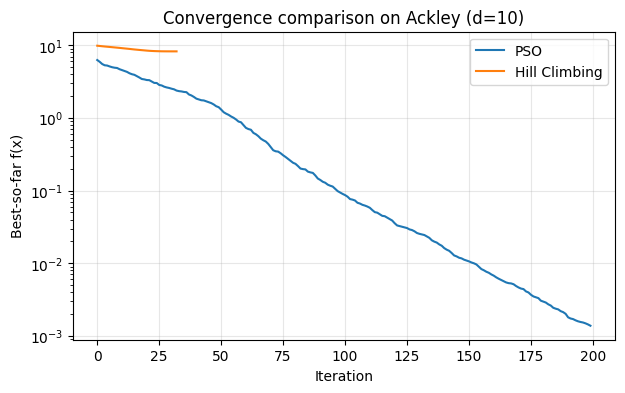

In [ ]:
# ---- Experiment 1: Convergence, robustness, time (fixed dimension) ----
DIM = 10
MAX_ITERS = 200
N_RUNS = 20

print(f"Running PSO and HC on Ackley (d={DIM}), {N_RUNS} runs each...")

pso_summary, pso_raw = run_many(
    method="pso",
    dim=DIM,
    max_iters=MAX_ITERS,
    n_runs=N_RUNS,
    base_seed=0,
    n_particles=40,
)

hc_summary, hc_raw = run_many(
    method="hc",
    dim=DIM,
    max_iters=MAX_ITERS,
    n_runs=N_RUNS,
    base_seed=10_000,
    step=0.1,
    variant="steepest",
)

print("\n=== PSO summary ===")
print(pso_summary)
print("\n=== Hill Climbing summary ===")
print(hc_summary)

plot_convergence_comparison(
    histories_pso=pso_raw["histories"],
    histories_hc=hc_raw["histories"],
    title=f"Convergence comparison on Ackley (d={DIM})",
    logy=True,
    output_path=OUT_PATH + f"convergence_comparison_d{DIM}.png",
)

## 2) Scalability (dim scaling)


>> Dimension d=5

>> Dimension d=10

>> Dimension d=20

>> Dimension d=40


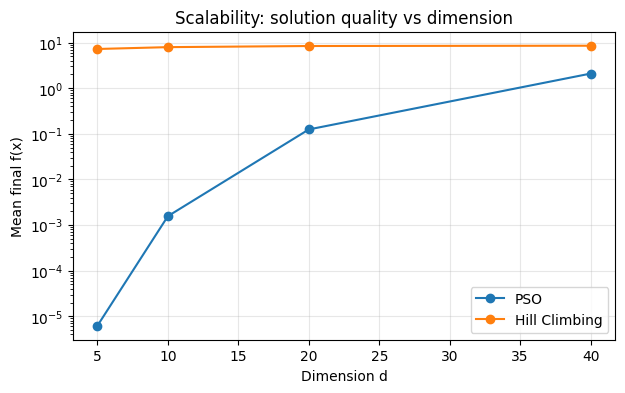

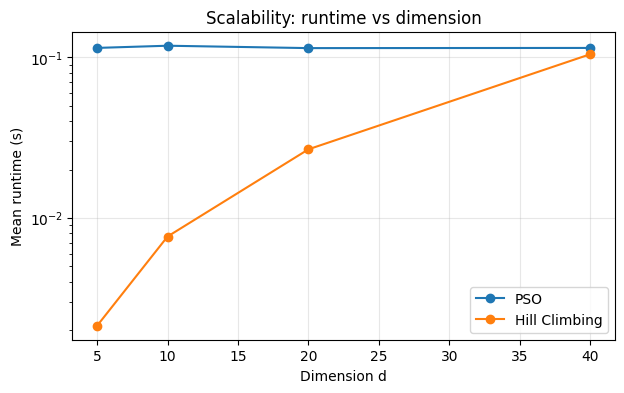

In [ ]:
# ---- Experiment 2: Scalability with dimension ----

DIMS = [5, 10, 20, 40]
MAX_ITERS_SCAL = 200
N_RUNS_SCAL = 10

summaries_pso = []
summaries_hc = []

for d in DIMS:
    print(f"\n>> Dimension d={d}")
    s_pso, _ = run_many(
        method="pso",
        dim=d,
        max_iters=MAX_ITERS_SCAL,
        n_runs=N_RUNS_SCAL,
        base_seed=0,
        n_particles=40,
    )
    s_hc, _ = run_many(
        method="hc",
        dim=d,
        max_iters=MAX_ITERS_SCAL,
        n_runs=N_RUNS_SCAL,
        base_seed=10_000,
        step=0.1,
        variant="steepest",
    )
    summaries_pso.append(s_pso)
    summaries_hc.append(s_hc)

# Collect arrays for plotting
best_pso = [s.best_f_mean for s in summaries_pso]
best_hc = [s.best_f_mean for s in summaries_hc]
time_pso = [s.time_mean for s in summaries_pso]
time_hc = [s.time_mean for s in summaries_hc]

plot_scalability_curve(
    DIMS,
    best_pso,
    best_hc,
    ylabel="Mean final f(x)",
    title="Scalability: solution quality vs dimension",
    logy=True,
    output_path=OUT_PATH + "scalability_solution_quality.png",
)

plot_scalability_curve(
    DIMS,
    time_pso,
    time_hc,
    ylabel="Mean runtime (s)",
    title="Scalability: runtime vs dimension",
    logy=True,
    output_path=OUT_PATH + "scalability_runtime.png",
)